In [1]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim import Adam
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset
import torch.nn.functional as F
import joblib
import os
import random
from PIL import Image

/home/raj/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def error_index(org_lables, error_ratio, num_classes):
    error = org_lables.copy()
    # determine the number of elements to update (error ratio of the list length)
    num_updates = int(len(org_lables) * error_ratio)

    # selecting the examples indicies randomly for labels to be replaced
    update_indices = random.sample(range(len(org_lables)), num_updates)

    # Replacing the selected lable with random other lable
    for idx in update_indices:
        error[idx] = random.sample([num for num in range(num_classes) if num != org_lables[idx]], 1)[0]
    return error


def csv_creator(root_dir, dataset_name):
    # define the class labels
    class_labels = os.listdir(root_dir)

    # create a dictionary to map class names to integers
    class_dict = {class_labels[i]: i for i in range(len(class_labels))}

    # create a list to store the image paths and class labels
    data = []

    # iterate over the class labels and their corresponding directories
    for label in class_labels:
        dir_path = os.path.join(root_dir, label)
        img_names = os.listdir(dir_path)
        # iterate over the image names and add their paths and class labels to the data list
        for img_name in img_names:
            img_path = os.path.join(dir_path, img_name)
            class_label = class_dict[label]
            data.append((img_path, class_label))
            
    random.shuffle(data)

    # calculate the split index for the train and test sets
    split_idx = int(0.8 * len(data))

    # create train and test dataframes
    train_df = pd.DataFrame(data[:split_idx], columns=['path', 'label'])
    test_df = pd.DataFrame(data[split_idx:], columns=['path', 'label'])

    org_lables = list(train_df['label'])
    num_classes = len(class_dict)
    
    
    error10 = error_index(org_lables, 0.1, num_classes)
    error20 = error_index(org_lables, 0.2, num_classes)
    error40 = error_index(org_lables, 0.4, num_classes)

    train_df = pd.DataFrame({'path':train_df['path'], 'lable':train_df['label'], 'error10':error10,
                             'error20':error20, 'error40':error40})


    # save the dataframes as CSV files
    train_df.to_csv(dataset_name+'train.csv', index=False)
    test_df.to_csv(dataset_name+'test.csv', index=False)

In [3]:
# specify the root directory for datasets
UCM_root_dir = '/kaggle/input/ucmerced/UCMerced_LandUse/Images'
Optimal31_root_dir = '/kaggle/input/optimal-31/OPTIMAL-31/Images'

UCM_classes = os.listdir(UCM_root_dir)
Optimal31_classes = os.listdir(Optimal31_root_dir)

csv_creator(UCM_root_dir, 'UCM_')
csv_creator(Optimal31_root_dir, 'Optimal31_')

In [4]:
# define a custom dataset class
class Dataset_creator(Dataset):
    def __init__(self, csv_file, col_indx = 1, transform=None):
        self.data = pd.read_csv(csv_file)
        self.col_indx = col_indx
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, self.col_indx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        return img, label

#  Load and normalizing dataset
transforms_train = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# create UCMercedDataset objects for training and testing
UCM_trainDataset = Dataset_creator('/kaggle/working/UCM_train.csv', 1, transform=transforms_train)
UCM_trainDataset10 = Dataset_creator('/kaggle/working/UCM_train.csv', 2, transform=transforms_train)
UCM_trainDataset20 = Dataset_creator('/kaggle/working/UCM_train.csv', 3, transform=transforms_train)
UCM_trainDataset40 = Dataset_creator('/kaggle/working/UCM_train.csv', 4, transform=transforms_train)
UCM_testDataset = Dataset_creator('/kaggle/working/UCM_test.csv', transform=transforms_test)

# create DataLoader objects for training and testing
UCM_trainDatasetLoader = DataLoader(UCM_trainDataset, batch_size=32, shuffle=True)
UCM_trainDatasetLoader10 = DataLoader(UCM_trainDataset10, batch_size=32, shuffle=True)
UCM_trainDatasetLoader20 = DataLoader(UCM_trainDataset20, batch_size=32, shuffle=True)
UCM_trainDatasetLoader40= DataLoader(UCM_trainDataset40, batch_size=32, shuffle=True)
UCM_testDatasetLoader = DataLoader(UCM_testDataset, batch_size=32, shuffle=False)

# create Optimal31Dataset objects for training and testing
Optimal31_trainDataset = Dataset_creator('/kaggle/working/Optimal31_train.csv', 1, transform=transforms_train)
Optimal31_trainDataset10 = Dataset_creator('/kaggle/working/Optimal31_train.csv', 2, transform=transforms_train)
Optimal31_trainDataset20 = Dataset_creator('/kaggle/working/Optimal31_train.csv', 3, transform=transforms_train)
Optimal31_trainDataset40 = Dataset_creator('/kaggle/working/Optimal31_train.csv', 4, transform=transforms_train)
Optimal31_testDataset = Dataset_creator('/kaggle/working/Optimal31_test.csv', transform=transforms_test)

# create DataLoader objects for training and testing
Optimal31_trainDatasetLoader = DataLoader(Optimal31_trainDataset, batch_size=32, shuffle=True)
Optimal31_trainDatasetLoader10 = DataLoader(Optimal31_trainDataset10, batch_size=32, shuffle=True)
Optimal31_trainDatasetLoader20 = DataLoader(Optimal31_trainDataset20, batch_size=32, shuffle=True)
Optimal31_trainDatasetLoader40= DataLoader(Optimal31_trainDataset40, batch_size=32, shuffle=True)
Optimal31_testDatasetLoader = DataLoader(Optimal31_testDataset, batch_size=32, shuffle=False)

In [5]:
# making tuples of (trainloader, testloader) for UCM and optimal-31 datasets 

UCM_dataloaders = [(UCM_trainDatasetLoader,UCM_testDatasetLoader), (UCM_trainDatasetLoader10,UCM_testDatasetLoader),
                  (UCM_trainDatasetLoader20,UCM_testDatasetLoader), (UCM_trainDatasetLoader40,UCM_testDatasetLoader)]

Optimal31_dataloaders = [(Optimal31_trainDatasetLoader,Optimal31_testDatasetLoader), (Optimal31_trainDatasetLoader10,Optimal31_testDatasetLoader),
                        (Optimal31_trainDatasetLoader20,Optimal31_testDatasetLoader), (Optimal31_trainDatasetLoader40,Optimal31_testDatasetLoader)]

noise_percent = [0, 10, 20, 40]

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
# function for model running time calculation
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [9]:
# Train and Test function for model

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)
        
        # Optimizer zero grad
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X)

        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()
        
        # Free up GPU memory
        del X, y, y_pred, loss
        torch.cuda.empty_cache()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    


    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
            # Free up GPU memory
            del X, y, test_pred
            torch.cuda.empty_cache()
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        return test_loss, test_acc

# MobileNet - UCMerced

In [10]:
torch.manual_seed(42)
import time

# Measure time
from timeit import default_timer as timer

all_dataset_train_time_mobilenet = []
all_dataset_train_loss = []
all_dataset_train_acc = []
all_dataset_test_loss = []
all_dataset_test_acc = []

for i, dataloader in enumerate(UCM_dataloaders):
    print(f"Training mobilenet for UCMerced Dataset with {noise_percent[i]}% noise in Traning samples")
    UCM_mobileNet = torchvision.models.mobilenet_v2()
    UCM_mobileNet.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=False),
                                nn.Linear(in_features=1280, out_features=len(UCM_classes), bias=True))
    train_dataloader, test_dataloader = dataloader[0], dataloader[1]
    model_mobileNet = UCM_mobileNet.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_mobileNet.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    
    # Train and test model 
    epochs = 100
    trainLoss, trainAcc = [], []
    testLoss, testAcc  = [], []

    train_time_start_mobileNet = timer()

    for epoch in range(epochs):
        print(f"Epoch: {epoch}\n---------")
        tr_l, tr_a = train_step(data_loader=train_dataloader, 
                    model=model_mobileNet, 
                    loss_fn=criterion,
                    optimizer=optimizer,
                    accuracy_fn=accuracy_fn,
                    device=device
        )
        
        trainLoss.append(tr_l)
        trainAcc.append(tr_a)

        ts_l, ts_a = test_step(data_loader=test_dataloader,
                    model=model_mobileNet,
                    loss_fn=criterion,
                    accuracy_fn=accuracy_fn,
                    device=device
        )

        testLoss.append(ts_l)
        testAcc.append(ts_a)


    train_time_end_mobileNet = timer()
    total_train_time_mobileNet = print_train_time(start=train_time_start_mobileNet,
                                            end=train_time_end_mobileNet,
                                            device=device)
    all_dataset_train_time_mobilenet.append(total_train_time_mobileNet)
    all_dataset_train_loss.append(trainLoss)
    all_dataset_train_acc.append(trainAcc)
    all_dataset_test_loss.append(testLoss)
    all_dataset_test_acc.append(testAcc)
    print("\n\n")


UCM_mobileNet_dict = {'Time':all_dataset_train_time_mobilenet,
                  'trainLoss':all_dataset_train_loss, 
                  'trainAcc':all_dataset_train_acc, 
                  'testLoss':all_dataset_test_loss, 
                  'testAcc':all_dataset_test_acc}

joblib.dump(UCM_mobileNet_dict, 'UCM_mobileNet_dict')

Training mobilenet for UCMerced Dataset with 0% noise in Traning samples
Epoch: 0
---------
Train loss: 2.98453 | Train accuracy: 8.08%
Test loss: 3.09195 | Test accuracy: 4.91%

Epoch: 1
---------
Train loss: 3.06867 | Train accuracy: 4.19%
Test loss: 3.07516 | Test accuracy: 2.90%

Epoch: 2
---------
Train loss: 3.04139 | Train accuracy: 5.54%
Test loss: 3.01535 | Test accuracy: 5.13%

Epoch: 3
---------
Train loss: 2.88835 | Train accuracy: 7.61%
Test loss: 2.81833 | Test accuracy: 8.93%

Epoch: 4
---------
Train loss: 2.73381 | Train accuracy: 10.91%
Test loss: 2.64779 | Test accuracy: 13.84%

Epoch: 5
---------
Train loss: 2.62369 | Train accuracy: 13.09%
Test loss: 2.57060 | Test accuracy: 11.61%

Epoch: 6
---------
Train loss: 2.52713 | Train accuracy: 15.57%
Test loss: 2.47770 | Test accuracy: 14.06%

Epoch: 7
---------
Train loss: 2.39231 | Train accuracy: 19.75%
Test loss: 2.35505 | Test accuracy: 22.32%

Epoch: 8
---------
Train loss: 2.29917 | Train accuracy: 22.29%
Test lo

['UCM_mobileNet_dict']

# MobileNet - Optima31

In [11]:
torch.manual_seed(42)
import time

# Measure time
from timeit import default_timer as timer

all_dataset_train_time_mobilenet = []
all_dataset_train_loss = []
all_dataset_train_acc = []
all_dataset_test_loss = []
all_dataset_test_acc = []

for i, dataloader in enumerate(Optimal31_dataloaders):
    print(f"Training mobilenet for Optimal31 Dataset with {noise_percent[i]}% noise in Traning samples")
    train_dataloader, test_dataloader = dataloader[0], dataloader[1]
    Optimal31_mobileNet = torchvision.models.mobilenet_v2()
    Optimal31_mobileNet.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=False),
                                nn.Linear(in_features=1280, out_features=len(Optimal31_classes), bias=True))
    model_mobileNet = Optimal31_mobileNet.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_mobileNet.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    
    # Train and test model 
    epochs = 100
    trainLoss, trainAcc = [], []
    testLoss, testAcc  = [], []

    train_time_start_mobileNet = timer()

    for epoch in range(epochs):
        print(f"Epoch: {epoch}\n---------")
        tr_l, tr_a = train_step(data_loader=train_dataloader, 
                    model=model_mobileNet, 
                    loss_fn=criterion,
                    optimizer=optimizer,
                    accuracy_fn=accuracy_fn,
                    device=device
        )
        
        trainLoss.append(tr_l)
        trainAcc.append(tr_a)

        ts_l, ts_a = test_step(data_loader=test_dataloader,
                    model=model_mobileNet,
                    loss_fn=criterion,
                    accuracy_fn=accuracy_fn,
                    device=device
        )

        testLoss.append(ts_l)
        testAcc.append(ts_a)


    train_time_end_mobileNet = timer()
    total_train_time_mobileNet = print_train_time(start=train_time_start_mobileNet,
                                            end=train_time_end_mobileNet,
                                            device=device)
    all_dataset_train_time_mobilenet.append(total_train_time_mobileNet)
    all_dataset_train_loss.append(trainLoss)
    all_dataset_train_acc.append(trainAcc)
    all_dataset_test_loss.append(testLoss)
    all_dataset_test_acc.append(testAcc)


Optimal31_mobileNet_dict = {'Time':all_dataset_train_time_mobilenet,
                  'trainLoss':all_dataset_train_loss, 
                  'trainAcc':all_dataset_train_acc, 
                  'testLoss':all_dataset_test_loss, 
                  'testAcc':all_dataset_test_acc}

joblib.dump(Optimal31_mobileNet_dict, 'Optimal31_mobileNet_dict')

Training mobilenet for Optimal31 Dataset with 0% noise in Traning samples
Epoch: 0
---------
Train loss: 3.17725 | Train accuracy: 6.78%
Test loss: 3.24507 | Test accuracy: 3.12%

Epoch: 1
---------
Train loss: 3.14334 | Train accuracy: 4.07%
Test loss: 3.09560 | Test accuracy: 4.46%

Epoch: 2
---------
Train loss: 3.08331 | Train accuracy: 4.95%
Test loss: 3.07117 | Test accuracy: 5.13%

Epoch: 3
---------
Train loss: 3.01524 | Train accuracy: 6.01%
Test loss: 2.91758 | Test accuracy: 7.81%

Epoch: 4
---------
Train loss: 2.75843 | Train accuracy: 11.20%
Test loss: 2.63383 | Test accuracy: 12.72%

Epoch: 5
---------
Train loss: 2.48205 | Train accuracy: 19.75%
Test loss: 2.33858 | Test accuracy: 24.55%

Epoch: 6
---------
Train loss: 2.27455 | Train accuracy: 25.35%
Test loss: 2.25760 | Test accuracy: 23.21%

Epoch: 7
---------
Train loss: 2.13070 | Train accuracy: 27.18%
Test loss: 2.05864 | Test accuracy: 29.24%

Epoch: 8
---------
Train loss: 2.10764 | Train accuracy: 27.12%
Test l

['Optimal31_mobileNet_dict']

In [2]:
UCM_mobileNet = joblib.load('UCM_mobileNet_dict')
Optimal31_mobileNet = joblib.load('Optimal31_mobileNet_dict')

In [3]:
UCM_mobileNet_times = UCM_mobileNet['Time']
UCM_mobileNet_trainLosses = UCM_mobileNet['trainLoss']
UCM_mobileNet_trainAccs = UCM_mobileNet['trainAcc']
UCM_mobileNet_testLosses = UCM_mobileNet['testLoss']
UCM_mobileNet_testAccs  = UCM_mobileNet['testAcc']

Optimal31_mobileNet_times = Optimal31_mobileNet['Time']
Optimal31_mobileNet_trainLosses = Optimal31_mobileNet['trainLoss']
Optimal31_mobileNet_trainAccs = Optimal31_mobileNet['trainAcc']
Optimal31_mobileNet_testLosses = Optimal31_mobileNet['testLoss']
Optimal31_mobileNet_testAccs  = Optimal31_mobileNet['testAcc']

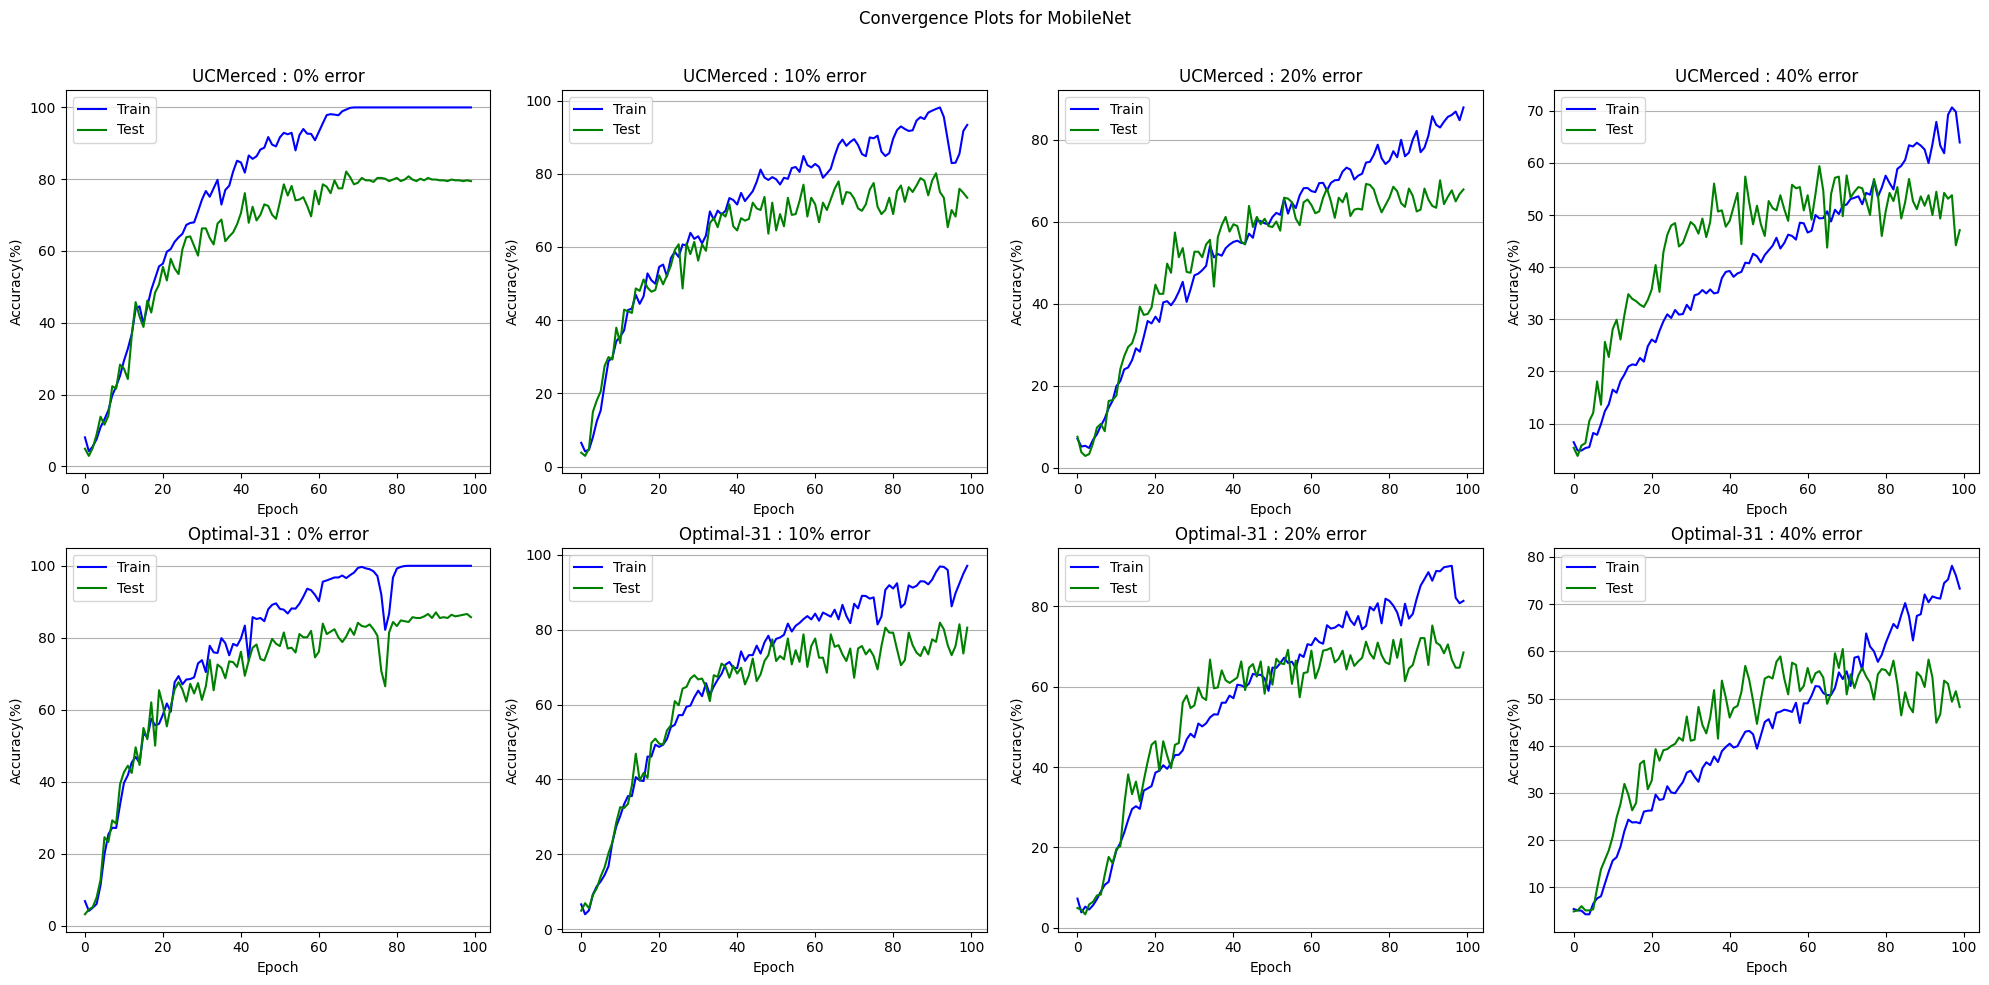

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# modelName = ['MobileNet', 'ShuffleNet', 'VIT']
sample_errors = ['0% error','10% error','20% error','40% error']
datasetName = ['UCMerced', 'Optimal-31']
modelsTrainAccs = [UCM_mobileNet_trainAccs, Optimal31_mobileNet_trainAccs]
modelsTestAccs = [UCM_mobileNet_testAccs, Optimal31_mobileNet_testAccs]

for i in range(2):
    for j in range(4):
        axs[i,j].plot(modelsTrainAccs[i][j], label='Train', color='blue')
        axs[i,j].plot(modelsTestAccs[i][j], label='Test', color='green')
        axs[i,j].set_xlabel('Epoch')
        axs[i,j].set_ylabel('Accuracy(%)')
        axs[i,j].set_title(f'{datasetName[i]} : {sample_errors[j]}')
        axs[i,j].grid(axis='y')
        axs[i,j].autoscale(enable=True, axis='Accuracy(%)')
        axs[i,j].legend()

# Call tight_layout to automatically adjust the spacing between subplots
plt.tight_layout()

# Add a title to the entire figure
fig.suptitle('Convergence Plots for MobileNet')

# Adjust the top margin to make more space for the suptitle
plt.subplots_adjust(top=0.9)

# Show the plot
plt.show()

In [17]:
from tabulate import tabulate

trainAccuracy_mat = []
testAccuracy_mat = []

for i in range(2):
    trainTemp = []
    testTemp = []
    for j in range(4):
        trainTemp.append(np.average(modelsTrainAccs[i][j][-4:]))
        testTemp.append(np.average(modelsTestAccs[i][j][-4:]))
    trainAccuracy_mat.append(trainTemp)
    testAccuracy_mat.append(testTemp)

# Define headers for columns and rows
headers = ['0% error','10% error','20% error','40% error']
row_headers = ['UCMerced', 'Optimal-31']

table1 = tabulate(trainAccuracy_mat, headers=headers, showindex=row_headers, tablefmt="fancy_grid")
table2 = tabulate(testAccuracy_mat, headers=headers, showindex=row_headers, tablefmt="fancy_grid")

print("Training accuracies after 100 Epoches")
print(table1,'\n')
print("Test accuracies after 100 Epoches")
print(table2)

Training accuracies after 100 Epoches
╒════════════╤════════════╤═════════════╤═════════════╤═════════════╕
│            │   0% error │   10% error │   20% error │   40% error │
╞════════════╪════════════╪═════════════╪═════════════╪═════════════╡
│ UCMerced   │        100 │     88.3697 │     86.365  │     68.3962 │
├────────────┼────────────┼─────────────┼─────────────┼─────────────┤
│ Optimal-31 │        100 │     93.5731 │     83.5938 │     75.6928 │
╘════════════╧════════════╧═════════════╧═════════════╧═════════════╛ 

Test accuracies after 100 Epoches
╒════════════╤════════════╤═════════════╤═════════════╤═════════════╕
│            │   0% error │   10% error │   20% error │   40% error │
╞════════════╪════════════╪═════════════╪═════════════╪═════════════╡
│ UCMerced   │    79.5759 │     73.1027 │     66.7969 │     49.5536 │
├────────────┼────────────┼─────────────┼─────────────┼─────────────┤
│ Optimal-31 │    86.2165 │     77.846  │     66.183  │     50.558  │
╘════════════╧══